# Sample a probability density with Neal's funnel using HMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js

import numpyro
import numpyro.distributions as dist

import torch
import zuko
import random
import pyro
from pyro import distributions as pyro_dist

from corner import corner

We model parameters $\mathbf{x}$ and $y$ where take $\mathbf{x}\in\mathbb{R}^n$ and $y\in\mathbb{R}$. The joint posterior probability density for some observed data $d$ is

\begin{equation*}
    p(\mathbf{x}, y | d) \propto p(d | \mathbf{x}) \cdot p(\mathbf{x} | y) \cdot p(y)\,.
\end{equation*}

with distributions

\begin{equation*}
    p(d | x_i) \sim \text{Laplace}(\mu=\mu_i, b=b_i)\,,
\end{equation*}

\begin{equation*}
    p(\mathbf{x} | y) \sim \mathcal{N}(\boldsymbol{\mu}=\mathbf{0}, \Sigma=e^{y}\,\mathbf{I})\,,
\end{equation*}

\begin{equation*}
    p(y) \sim \text{Cauchy}(x_0=0, \gamma=1)\,.
\end{equation*}

In [2]:
# dimension of x parameter
x_dim = 5

# characterize likelihood
mu_key, b_key = jr.split(jr.key(0))
Laplace_mus = jr.uniform(key=mu_key,
                 shape=(x_dim,),
                 minval=-1.,
                 maxval=1.)
Laplace_bs = jr.uniform(key=b_key,
                shape=(x_dim,),
                minval=5.,
                maxval=10.)

# characterize prior on y
Cauchy_x0 = 0.
Cauchy_gamma = 0.5

In [3]:
# likelihood
@jit
def lnlike(x):
    return jnp.sum(js.stats.laplace.logpdf(x, loc=Laplace_mus, scale=Laplace_bs))

# prior on x
@jit
def x_lnprior(x, y):
    return js.stats.multivariate_normal.logpdf(x=x,
                                               mean=jnp.zeros(x_dim),
                                               cov=jnp.eye(x_dim)*jnp.exp(y))

# prior on y
@jit
def y_lnprior(y):
    return js.stats.cauchy.logpdf(x=y,
                                  loc=Cauchy_x0,
                                  scale=Cauchy_gamma)

# prior on y using torch for later
torch_Cauchy = torch.distributions.Cauchy(loc=Cauchy_x0, scale=Cauchy_gamma)
def y_lnprior_torch(y):
    return torch_Cauchy.log_prob(y)

# posterior
@jit
def lnpost(x, y):
    return lnlike(x) + x_lnprior(x, y) + y_lnprior(y)

In [4]:
# sample funnel with HMC
def neals_funnel():
    x = numpyro.sample('x', dist.Uniform(-1000., 1000.).expand((x_dim,)))
    y = numpyro.sample('y', dist.Uniform(-1000., 1000.))
    numpyro.factor('lnpost', lnpost(x, y))

nuts_kernel = numpyro.infer.NUTS(neals_funnel,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e4))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['x'],
                          samples_dict['y'][:, None]),
                          axis=1)

sample: 100%|██████████| 20000/20000 [00:04<00:00, 4550.40it/s, 7 steps of size 3.43e-01. acc. prob=0.88] 


In [38]:
# standardize funnel for better sampling
def neals_funnel_standardized():
    x_standard = numpyro.sample('x_standard', dist.Normal().expand((x_dim,)))
    y = numpyro.sample('y', dist.Cauchy(loc=Cauchy_x0, scale=Cauchy_gamma))
    # y = numpyro.sample('y', dist.Uniform(-100., 10.))
    x = x_standard * jnp.exp(y / 2)
    numpyro.deterministic('x', x)
    numpyro.factor('lnlike', lnlike(x))

nuts_kernel_st = numpyro.infer.NUTS(neals_funnel_standardized,
                                    dense_mass=True)
mcmc_st = numpyro.infer.MCMC(sampler=nuts_kernel_st,
                             num_warmup=int(1e4),
                             num_samples=int(1e5))
mcmc_st.run(jr.key(1))
samples_dict_st = mcmc_st.get_samples()
samples_st = np.concatenate((samples_dict_st['x'],
                             samples_dict_st['y'][:, None]),
                             axis=1)

sample: 100%|██████████| 110000/110000 [00:21<00:00, 5220.75it/s, 31 steps of size 1.20e-01. acc. prob=0.87]


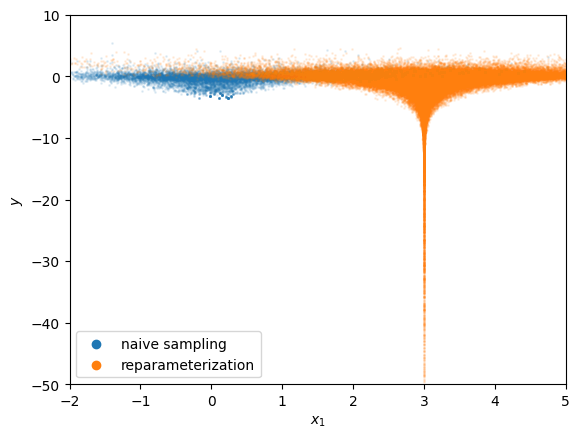

In [39]:
# plot samples
ndx1 = 0
ndx2 = -1
x_labels = np.array([rf'$x_{{{i}}}$' for i in np.arange(1, x_dim + 1)])
labels = np.concatenate((x_labels, np.array([r'$y$'])))
plt.scatter(samples[:, ndx1], samples[:, ndx2], s=1, alpha=0.1)
plt.scatter(3 + samples_st[:, ndx1], samples_st[:, ndx2], s=1, alpha=0.1)
plt.scatter([], [], color='C0', label='naive sampling')
plt.scatter([], [], color='C1', label='reparameterization')
plt.xlim(-200, 750)
plt.xlabel(labels[ndx1])
plt.ylabel(labels[ndx2])
plt.xlim(-2, 5)
plt.ylim(-50, 10)
plt.legend()
plt.show()

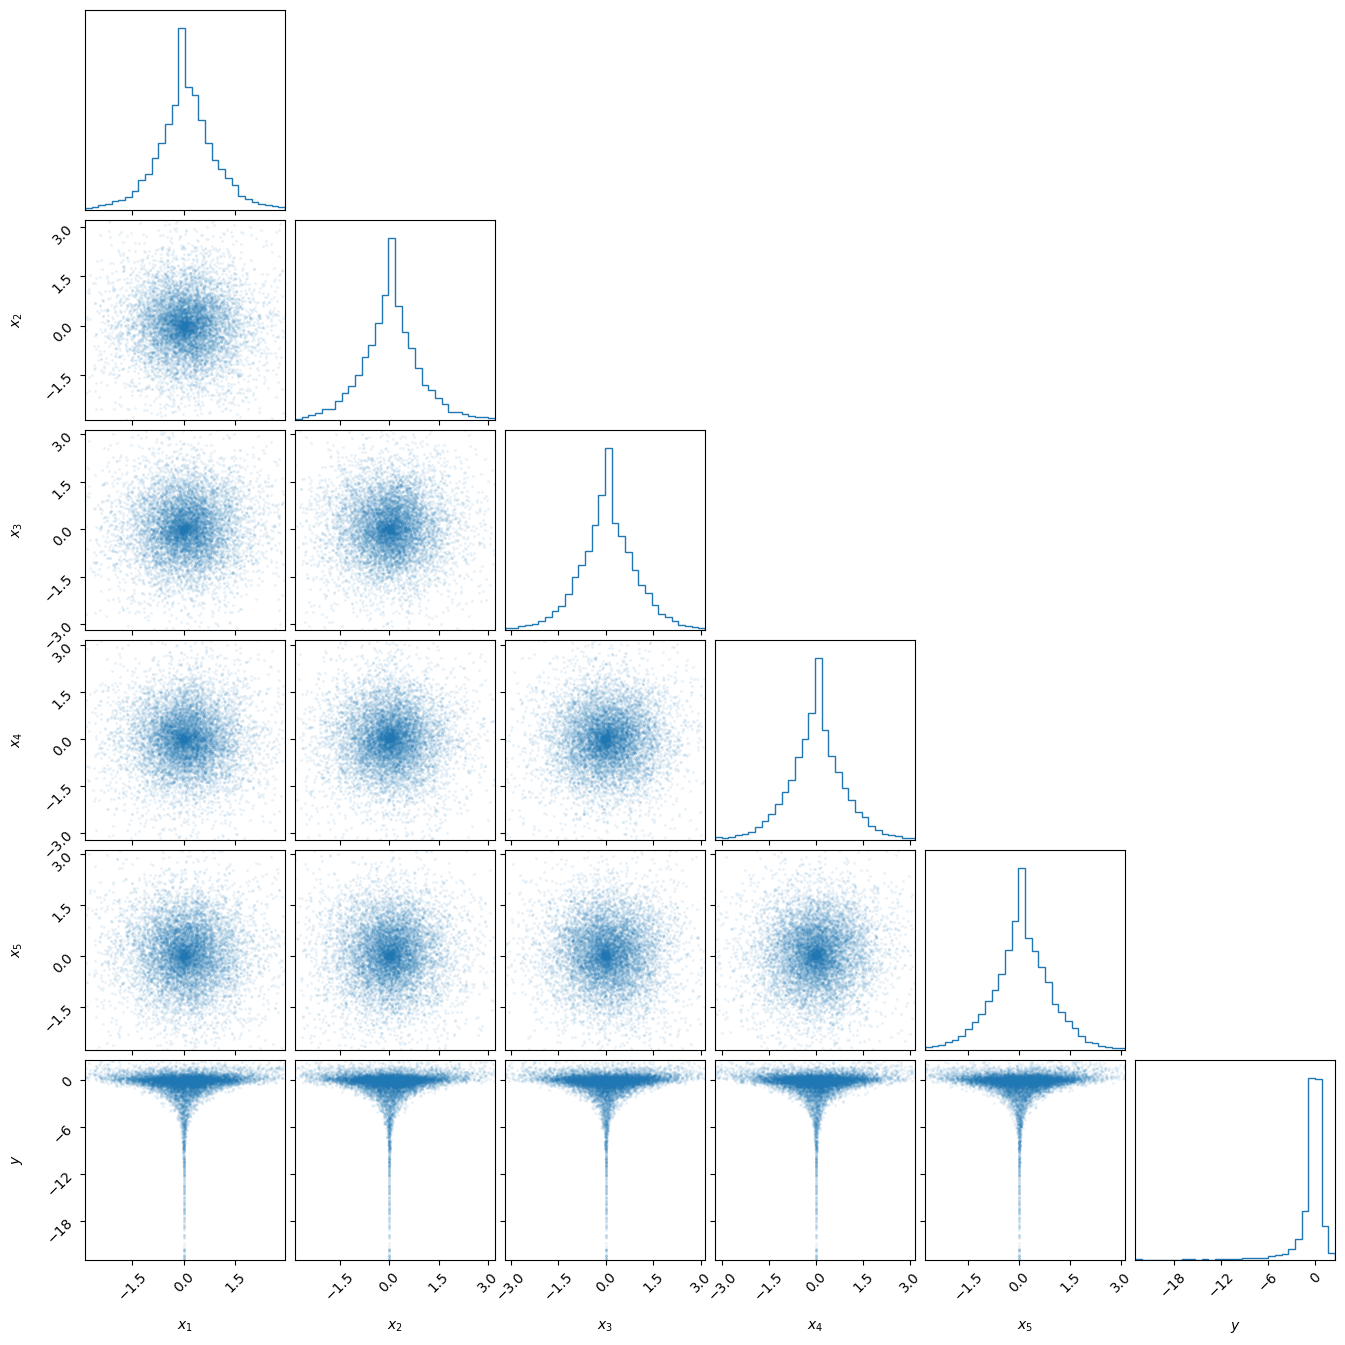

In [7]:
fig = corner(samples_st,
             labels=labels,
             range=[0.99]*samples_st.shape[1],
             color='C0',
             plot_contours=False,
             plot_density=False,
             bins=30)

Instead of sampling over $y$ which leads to a strong funnel, we sample the "extended" density,

\begin{equation*}
    p(\mathbf{x}, \mathbf{z} | d) \propto p(d | \mathbf{x}) \cdot p(\mathbf{x} | \mathbf{z}) \cdot p(\mathbf{z})
\end{equation*}

where $\mathbf{z}\in\mathbb{R}^n$ with

\begin{equation*}
    p(\mathbf{x} | \mathbf{z}) \sim \mathcal{N}(\mathbf{\mu}=\mathbf{0}, \Sigma=\text{diag}(\mathbf{z}))\,.
\end{equation*}

In [8]:
def extended_model():
    # sample in log(z)
    log10_z = numpyro.sample('log10_z', dist.Uniform(-10., 4.).expand((x_dim,)))
    # conditional prior on x
    x_standard = numpyro.sample('x_standard', dist.Normal().expand((x_dim,)))
    x = numpyro.deterministic('x', x_standard * jnp.sqrt(10. ** log10_z))
    # likelihood
    numpyro.factor('lnlike', lnlike(x))

nuts_kernel_extended = numpyro.infer.NUTS(extended_model,
                                          dense_mass=False)
mcmc_extended = numpyro.infer.MCMC(sampler=nuts_kernel_extended,
                                      num_warmup=int(1e4),
                                      num_samples=int(1e6))
mcmc_extended.run(jr.key(2))
samples_dict_extended = mcmc_extended.get_samples()
extended_samples = np.concatenate((samples_dict_extended['x'],
                                   samples_dict_extended['log10_z']),
                                   axis=1)

sample: 100%|██████████| 1010000/1010000 [02:26<00:00, 6904.84it/s, 7 steps of size 4.04e-01. acc. prob=0.80] 


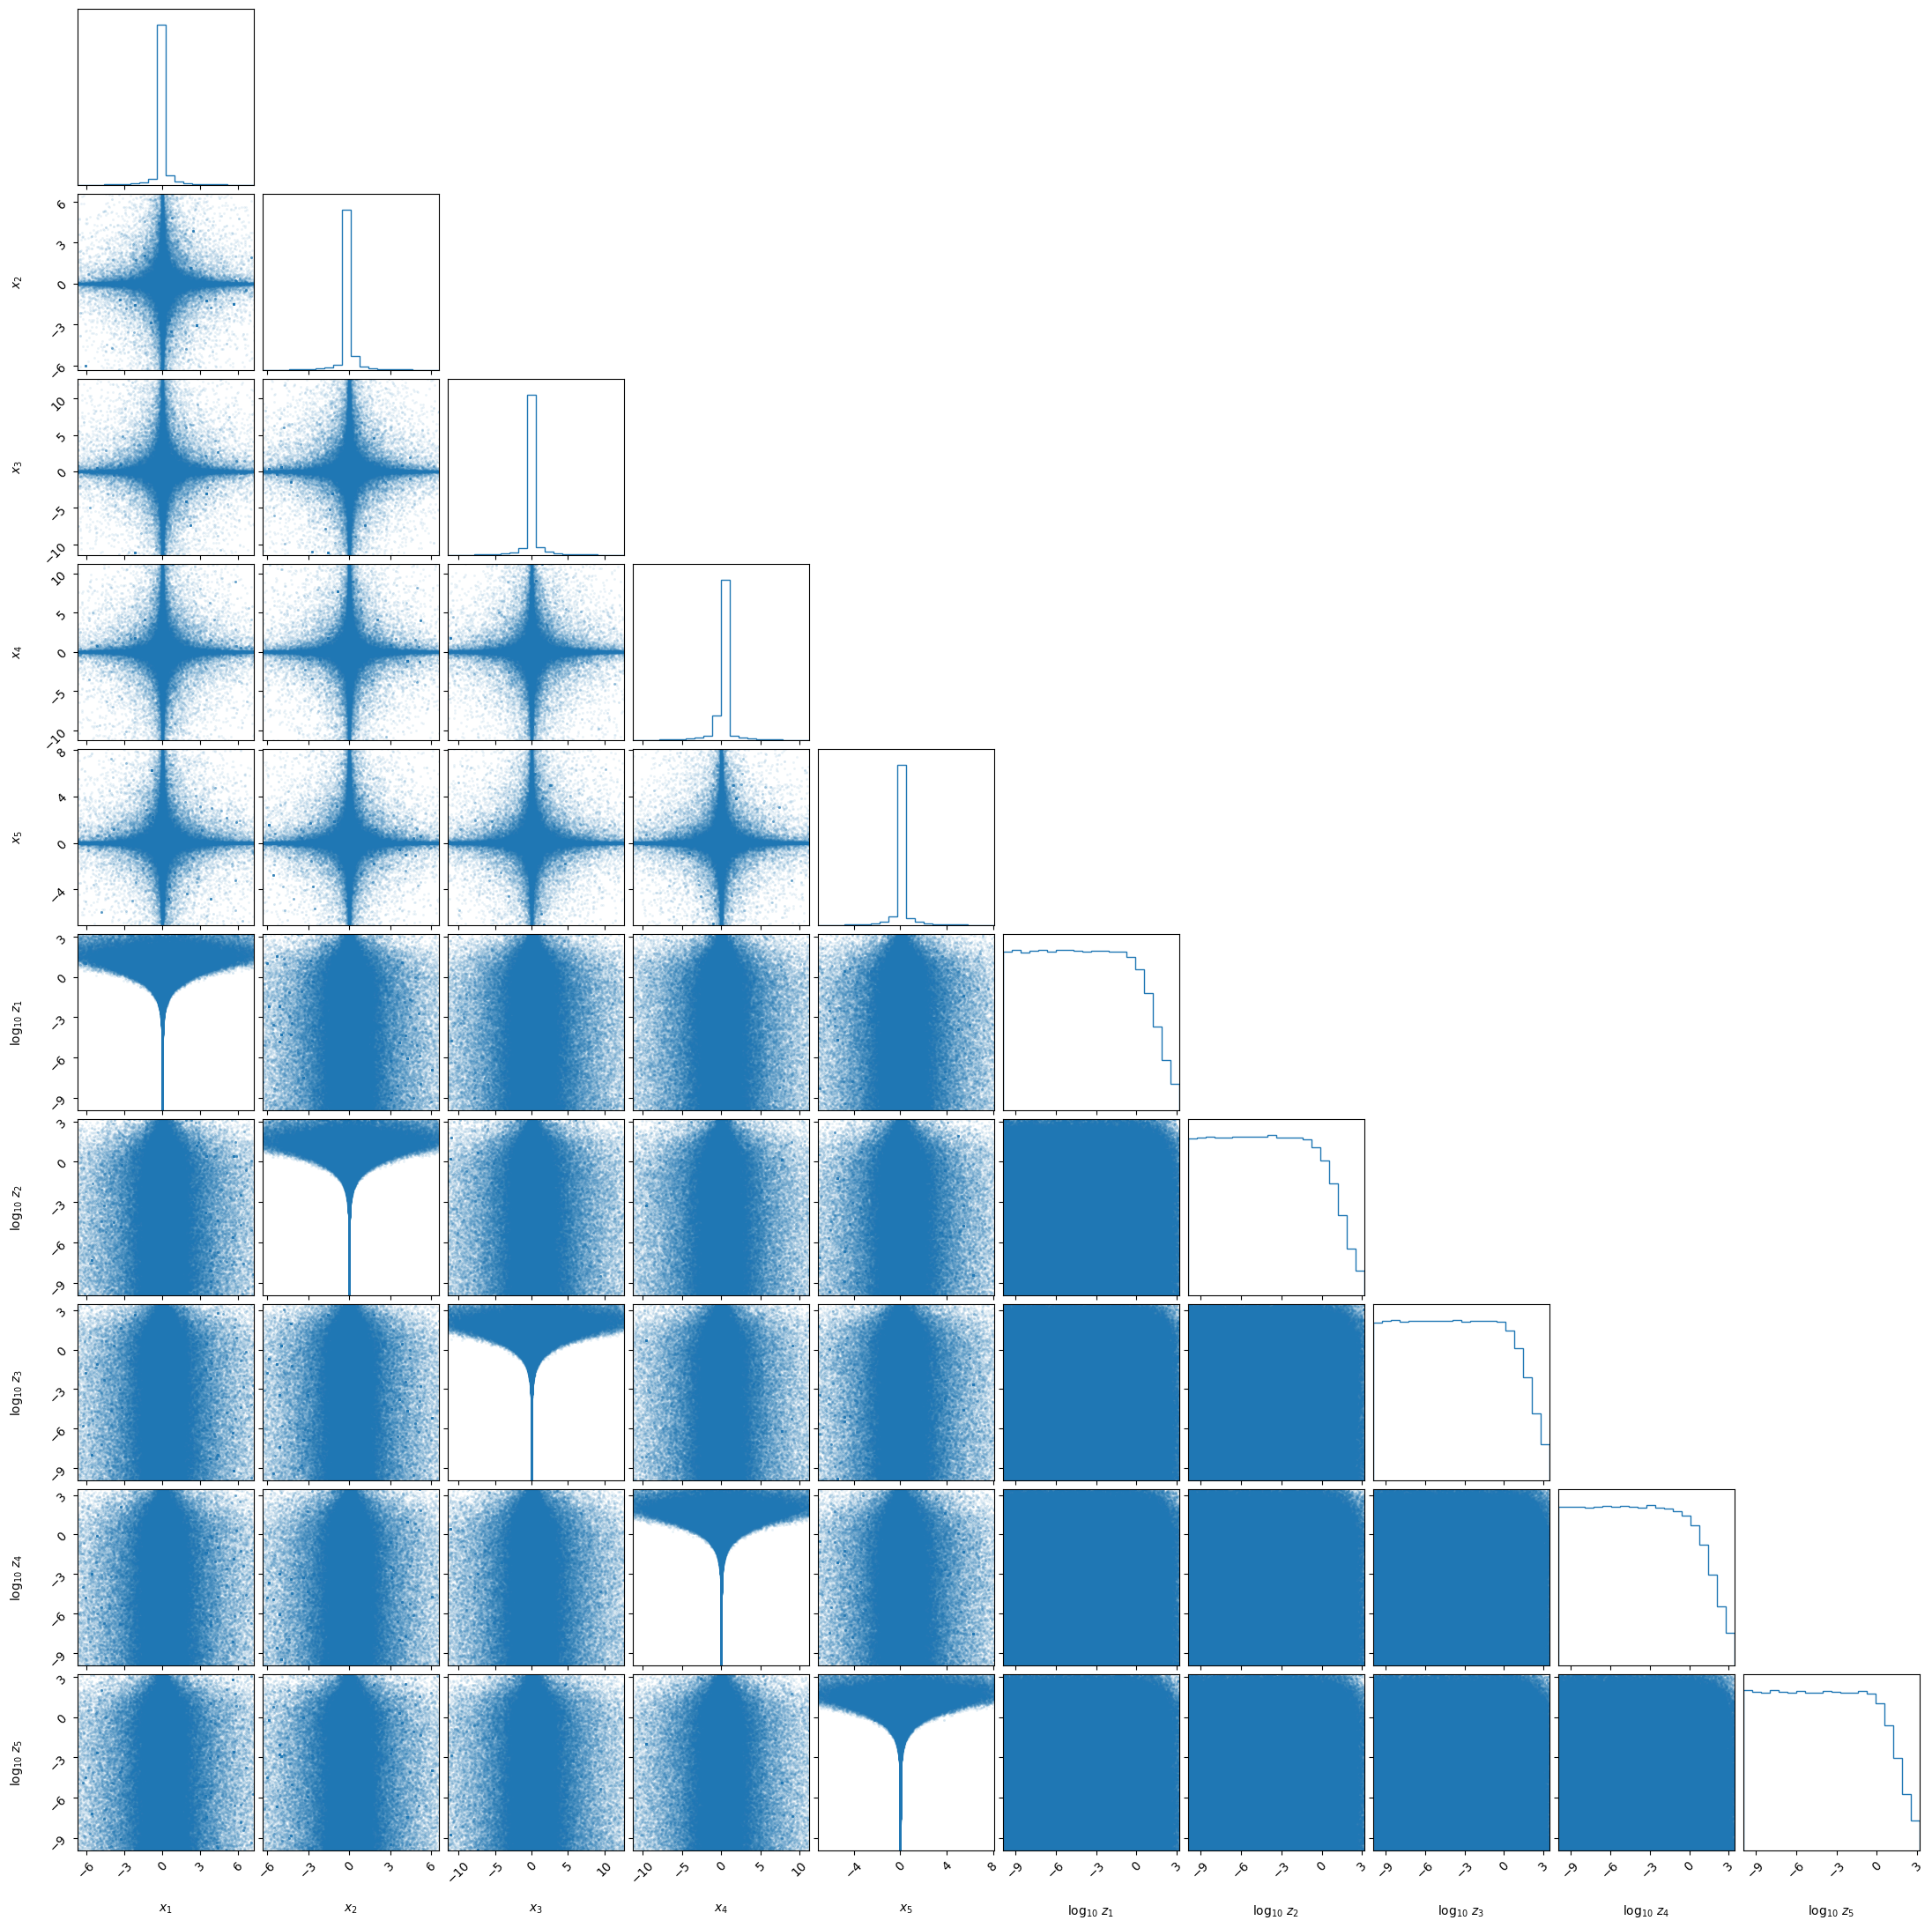

In [9]:
z_labels = np.array([rf'$\log_{{{10}}}\,z_{{{i}}}$' for i in np.arange(1, x_dim + 1)])
extended_labels = np.concatenate((x_labels, z_labels))
fig = corner(extended_samples,
             labels=extended_labels,
             range=[0.99]*extended_samples.shape[1],
             color='C0',
             plot_contours=False,
             plot_density=False,
             bins=20)

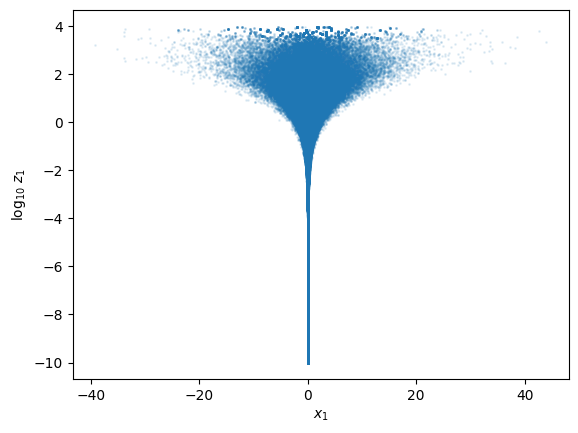

In [10]:
ndx1 = 0
ndx2 = x_dim
plt.scatter(extended_samples[:, ndx1], extended_samples[:, ndx2],
            color='C0', s=1, alpha=0.1)
plt.xlabel(extended_labels[ndx1])
plt.ylabel(extended_labels[ndx2])
plt.show()

## Second stage sampling

Now we model $z_i = e^{y/2}$. First we need to learn the distribution on $\mathbf{z}$ with a normalizing flow.

In [11]:
log10_z_samples = torch.tensor(extended_samples[::10, x_dim:])

In [12]:
# transformation to "normalized" samples
B = 4
max_val = torch.max(log10_z_samples, axis=0).values
min_val = torch.min(log10_z_samples, axis=0).values
h = (max_val - min_val) / 2
mean_val = (max_val + min_val) / 2

def normalize(sample):
    return B * (sample - mean_val) / h

def unnormalize(sample):
    return sample * h / B + mean_val

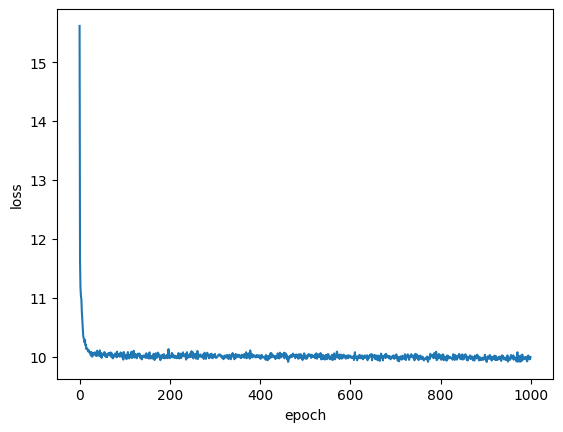

In [13]:
torch.set_default_dtype(torch.float64)

# define flow
flow = zuko.flows.spline.NSF(features=x_dim,
                             context=0,
                             bins=8,
                             passes=2,
                             hidden_features=[512] * 4)

# data used to train flow
normalized_samples = normalize(log10_z_samples).to(torch.float64)

# attributes of training
batch_size = 512
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
losses = []
num_epoch = int(1e4)

# train flow
for epoch in range(num_epoch):

    idx = random.sample(range(normalized_samples.shape[0]), k=batch_size)
    fair_draws = normalized_samples[idx]

    loss = -flow().log_prob(fair_draws).mean()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    # print losses and update progress
    if epoch % 10 == 0:
        print(f'{np.round(epoch / num_epoch * 100, 3)}%   loss = {loss.item()}', end='\r')
        losses.append(loss.item())
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [14]:
normalized_flow_samples = flow().sample((int(1e5),))
flow_samples = unnormalize(normalized_flow_samples)

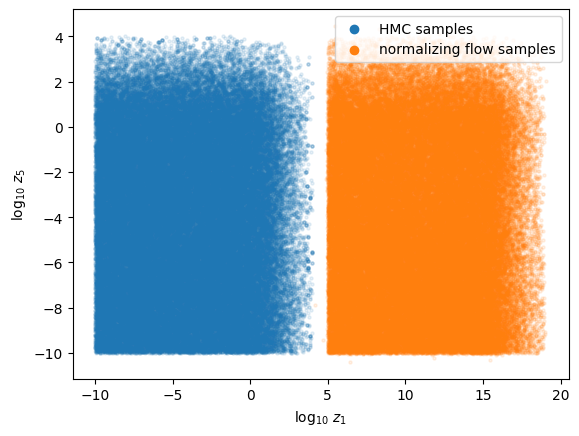

In [37]:
# plot flow samples
ndx1 = 0
ndx2 = 4
plt.scatter(log10_z_samples[:, ndx1], log10_z_samples[:, ndx2],
         color='C0', alpha=0.1, s=5)
plt.scatter([], [], color='C0', label='HMC samples')
plt.scatter(flow_samples[:, ndx1] + 15, flow_samples[:, ndx2],
         color='C1', alpha=0.1, s=5)
plt.scatter([], [], color='C1', label='normalizing flow samples')
plt.xlabel(z_labels[ndx1])
plt.ylabel(z_labels[ndx2])
plt.legend()
plt.show()

In [16]:
# second stage density
def second_stage_lnpost(y):
    # prior 
    lnprior_val = y_lnprior_torch(y)
    # likelihood
    lnlike_val = flow().log_prob(normalize(torch.log10(torch.ones(x_dim) * torch.exp(y / 2.))))
    return lnprior_val + lnlike_val

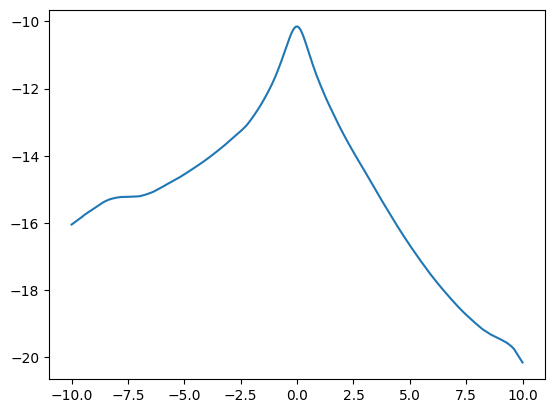

In [17]:
y_vals = torch.linspace(-10, 10, 500)
lnposts = np.array([second_stage_lnpost(y).item() for y in y_vals])
plt.plot(y_vals.detach().numpy(), lnposts)
plt.show()

In [18]:
# do HMC NUTS with Pyro
def second_stage_sampling_model():
    y = pyro.sample('y', pyro_dist.Uniform(-20., 20.))
    pyro.factor('lnpost', second_stage_lnpost(y))

pyro_nuts_kernel = pyro.infer.NUTS(model=second_stage_sampling_model,
                                   full_mass=True)
pyro_mcmc = pyro.infer.MCMC(kernel=pyro_nuts_kernel,
                            warmup_steps=500,
                            num_samples=int(2e4))
pyro_mcmc.run()
y_samples = pyro_mcmc.get_samples()['y']

Sample: 100%|██████████| 20500/20500 [08:40, 39.38it/s, step size=6.84e-01, acc. prob=0.862]


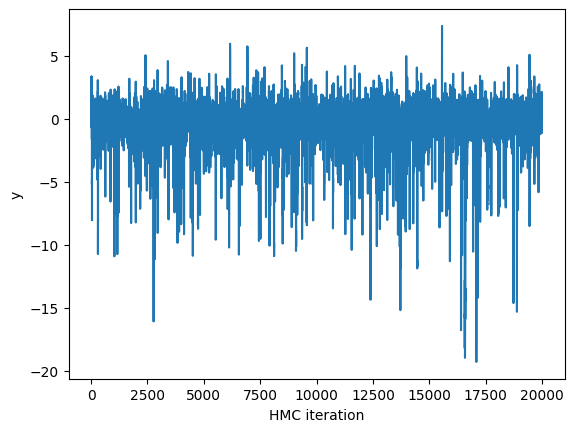

In [19]:
y_samples = y_samples.detach().numpy()
plt.plot(y_samples)
plt.xlabel('HMC iteration')
plt.ylabel('y')
plt.show()

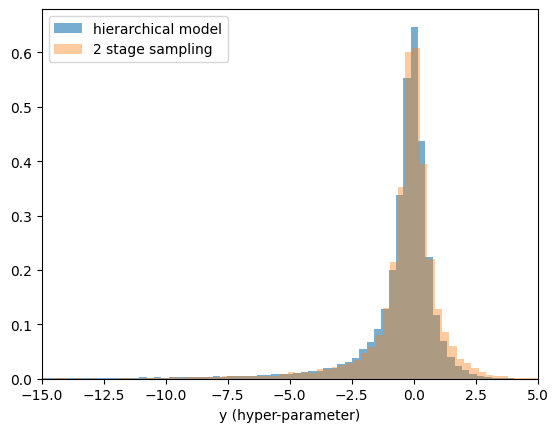

In [45]:
from scipy.stats import gaussian_kde

plt.hist(samples_st[:, -1], bins=3000, density=True,
         label='hierarchical model', alpha=0.6)
plt.hist(y_samples[::1], bins=90, alpha=0.4, density=True,label='2 stage sampling')
plt.xlabel('y (hyper-parameter)')
plt.xlim(-15, 5)
plt.legend()
plt.show()